In [6]:
import pandas as pd
import numpy as np
import sys
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sbrn
import matplotlib as mpl
from copy import deepcopy,copy
from ipywidgets import IntProgress
from itertools import chain
from IPython.display import display
from datetime import datetime
import pickle
import os

states=['New York','Massachusetts','California','Florida','Washington','Texas']

color_dict={'Gravity pow':(143, 194, 165),
            'Gravity exp':(102, 194, 165),
            'Radiation':(84, 164, 165),
            'BMS Best':(218, 141, 98),
            'BMS Plausible':(218, 141, 98),
            'BMS Ensemble':(249, 166, 98),
            'BMS Predictive':(255, 199, 98),
            'Random Forest':(141,160,203),
            'Deep Gravity':(220, 160, 203)
           }

In [2]:
name=open('./data/checkpoints/scatter_C_2023_07_20-07_56_07.pkl', "rb")
scatter_models_C_final=pickle.load(name)
name.close()

In [7]:
def window_selection(a,b,lower,upper):
    a_new=[i for i,j in zip(a,b) if i>lower and i<=upper]
    b_new=[j for i,j in zip(a,b) if i>lower and i<=upper]
    return a_new,b_new
def common_part_of_commuters(values1, values2,lower,upper):
    values1,values2=window_selection(values1,values2,lower,upper)
    tot = np.sum(values1) + np.sum(values2)
    return 2.0 * np.sum(np.minimum(values1, values2)) / tot
def RMSE(real,predicted):
    #from sklearn.metrics import mean_squared_error
    #return mean_squared_error(real,predicted, squared=False)
    real,predicted=delete_nan(real,predicted)
    return np.sqrt(np.square(np.subtract(real,predicted)).mean())
def MRE(real,predicted):
    real,predicted=delete_nan(real,predicted)
    return np.array(list(np.abs((y-y1)/y1) for y,y1 in zip(predicted,real))).mean()
def MLogRatio(real,predicted):
    real,predicted=delete_nan(real,predicted)
    return np.array(list(np.abs(np.log(y1/y)) for y,y1 in zip(predicted,real))).mean()
def AbsErr(real,predicted,lower,upper):
    #from sklearn.metrics import mean_squared_error
    #return mean_squared_error(real,predicted, squared=False)
    real,predicted=window_selection(real,predicted,lower,upper)
    return np.abs(np.subtract(real,predicted))
def RE(real,predicted,lower,upper):
    real,predicted=window_selection(real,predicted,lower,upper)
    return [np.abs((y-y1)/y1) for y,y1 in zip(predicted,real)]
def LogRatio(real,predicted,lower,upper):
    real,predicted=window_selection(real,predicted,lower,upper)
    return [np.abs(np.log(y1/y)) for y,y1 in zip(predicted,real)]
metric_functions=[common_part_of_commuters,AbsErr,RE,LogRatio]

In [8]:
for key, item in scatter_models_C_final[states[0]].items():
    print(key,len(item))

Random Forest 5952
test 5952
Deep Gravity 5952
testDG 5952
Radiation 5952
Gravity pow 5952
Gravity exp 5952
BMS Plausible 5952
BMS Ensemble 5952
BMS-MuDF(ens,best) 5952
BMS Predictive 5952
BMS-MuDF(ens,best ae) 5952


[<matplotlib.lines.Line2D object at 0x7fd96a036b20>, <matplotlib.lines.Line2D object at 0x7fd969efff70>, <matplotlib.lines.Line2D object at 0x7fd969f19280>, <matplotlib.lines.Line2D object at 0x7fd969f19550>, <matplotlib.lines.Line2D object at 0x7fd969f19820>, <matplotlib.lines.Line2D object at 0x7fd969f19af0>, <matplotlib.lines.Line2D object at 0x7fd969f19dc0>, <matplotlib.lines.Line2D object at 0x7fd969f290d0>] ['Gravity pow', 'Gravity exp', 'Radiation', 'BMS Plausible', 'BMS Ensemble', 'BMS Predictive', 'Random Forest', 'Deep Gravity']


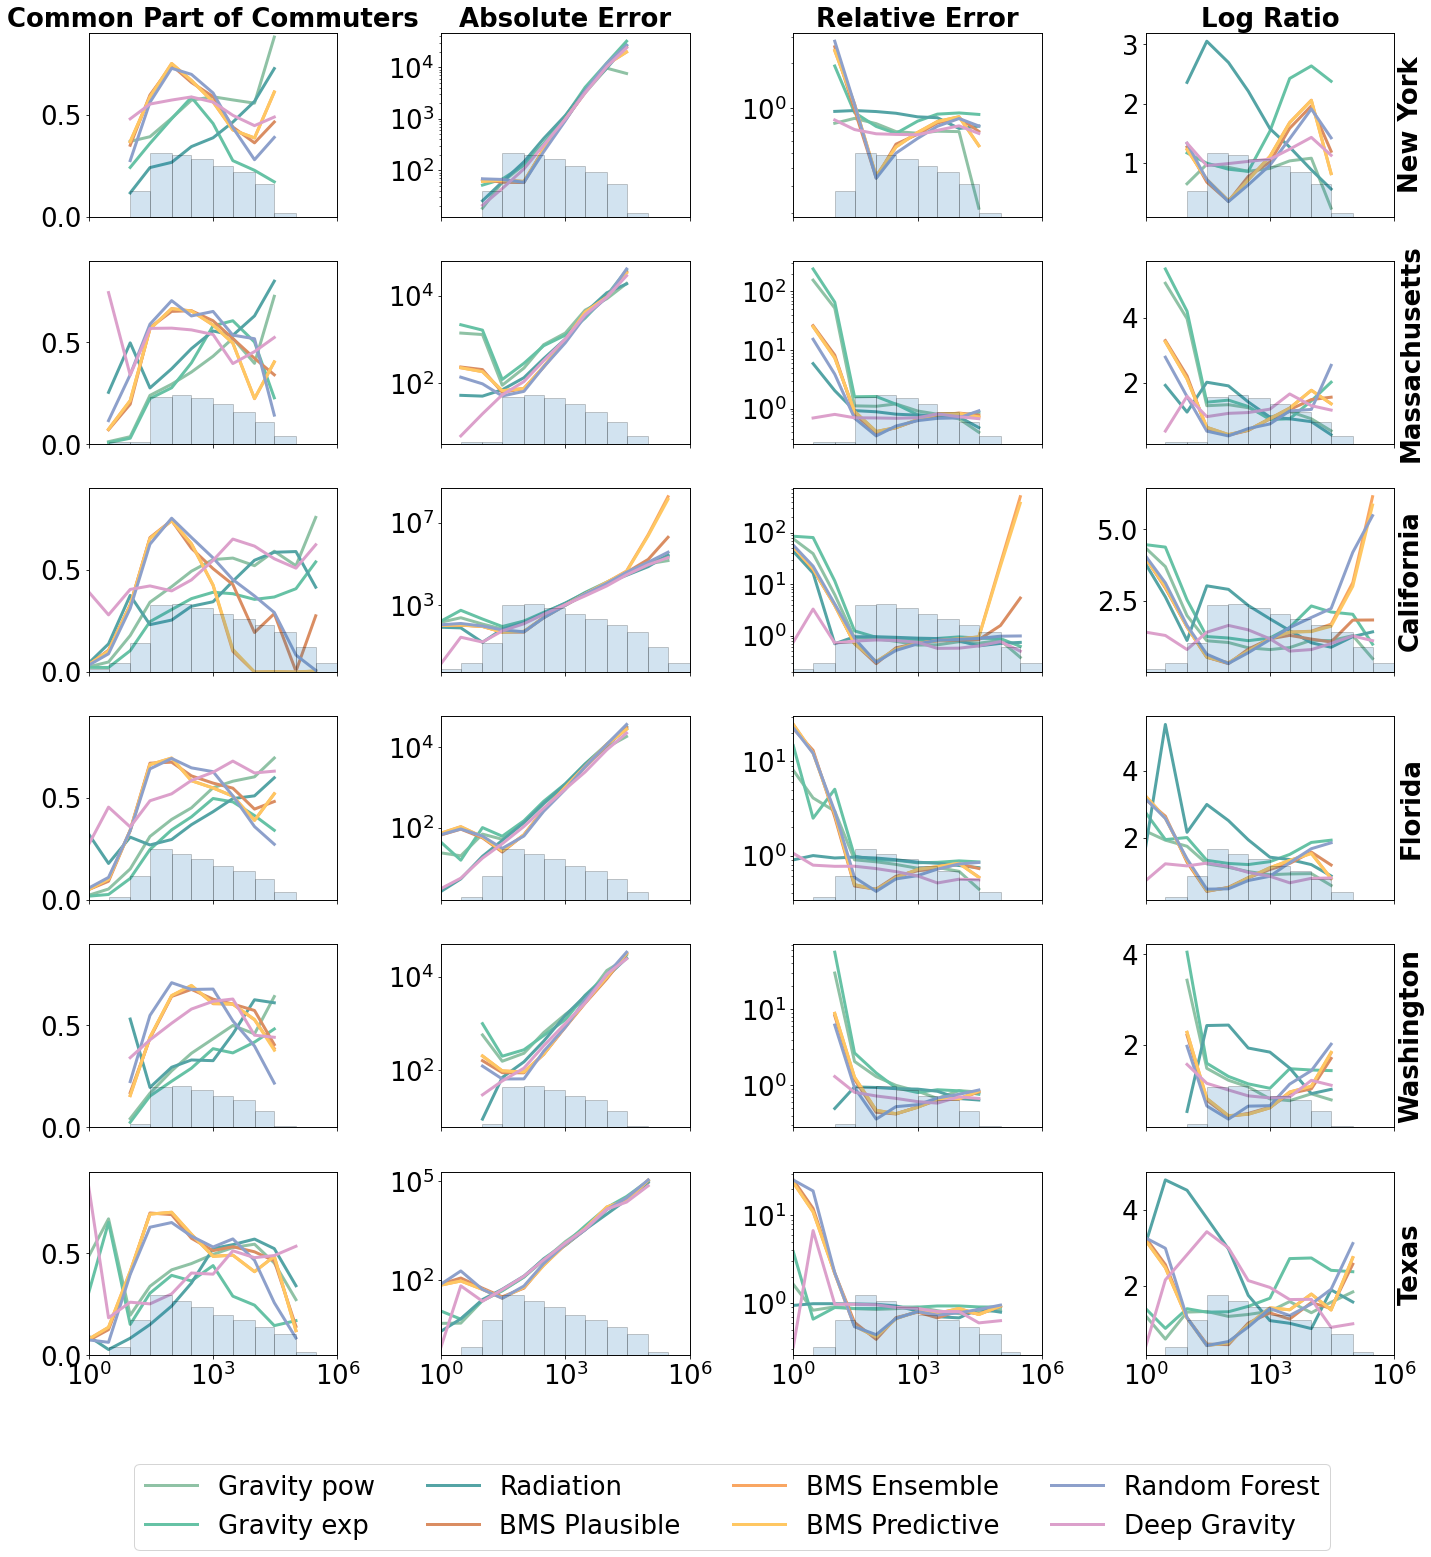

In [9]:
import matplotlib.cm as cm

SMALL_SIZE = 26
MEDIUM_SIZE = 26
BIGGER_SIZE = 26
#print(_dict,df)
windows=[1,3,10,30,100,300,1e3,3e3,1e4,3e4,1e5,3e5,1e6,3e6]
models=['Gravity pow','Gravity exp','Radiation','BMS Plausible','BMS Ensemble','BMS Predictive','Random Forest','Deep Gravity']
#models=['BMS Plausible','BMS Ensemble','BMS Predictive','Deep Gravity']

metrics=['CPC','AbsErr','RE','LogRatio']
size=(20, 20)
#print(metric,model)
colors=[[i/255. for i in color_dict[key]]+[1] for key in models]
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



fig, axs = plt.subplots(len(states),len(metrics),figsize=size,sharex='col')
for i,m in enumerate(metrics):
    for j,s in enumerate(states):
        # Get de value for each model
        data=scatter_models_C_final[s]
        for l,model in enumerate(models):
            #print(m)
            res=[]
            num_points=[]
            for k in range(0,len(windows)-1):
                # Select flows in range
                #print(windows[k],windows[k+1])
                if l==0: num_points.append(len([point for point in data['test'] if windows[k]<point<windows[k+1]]))
                if model=='Deep Gravity':
                    aux=metric_functions[i](data['testDG'],data['Deep Gravity'],windows[k],windows[k+1])
                else:
                    aux=metric_functions[i](data['test'],data[model],windows[k],windows[k+1])
                    
                if m=='CPC':
                    res.append(aux)
                    if j==0:
                        axs[j,i].set_title('Common Part of Commuters', fontweight="bold")
                    axs[j,i].set_ylim([0,0.9])
                else:
                    res.append(np.median(aux))
            #print(res)
            axs[j,i].plot(windows[:len(res)],res, color=colors[l],label=model,lw=3.)
            axs[j,i].set_xscale('log')
            if i==len(metrics)-1:
                axs[j,i].set_ylabel(s, fontweight="bold")
                axs[j,i].yaxis.set_label_position("right")
                #axs[j,i].yaxis.tick_right()
            if j==0 and m=='RE':
                axs[j,i].set_title('Relative Error', fontweight="bold")
            elif j==0 and m=='LogRatio':
                axs[j,i].set_title('Log Ratio', fontweight="bold")
            elif j==0 and m=='AbsErr':
                axs[j,i].set_title('Absolute Error', fontweight="bold")
            if m=='AbsErr' or m=='RE':
                axs[j,i].set_yscale('log')
            axs[j,i].set_xlim([1,1e6])
            if l==0:
                #print(windows[:len(res)], num_points, np.diff(windows[:len(res)]))
                #print(len(windows[:len(res)]), len(num_points), len(np.diff(windows[:len(res)+1])))
                tx = axs[j,i].twinx()
                tx.bar(windows[:len(res)], num_points, log=True,ec="k", align="edge", alpha=0.2, width=np.diff(windows[:len(res)+1]))
                tx.set_ylim([0,1e10])
                tx.set_xlim([1,1e6])
                tx.set_xticks([])
                tx.set_yticks([])

lines, labels = axs[0,0].get_legend_handles_labels()
print(lines, labels)
#lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels,loc='lower center',ncol=4,bbox_to_anchor=(0.5,-0.1))                
fig.tight_layout()
fig.show()
#fig.savefig('./Plots/week1_metrics_windows.pdf',bbox_inches='tight',dpi=300)

[<matplotlib.lines.Line2D object at 0x7fd9640188b0>, <matplotlib.lines.Line2D object at 0x7fd95fdc0d00>, <matplotlib.lines.Line2D object at 0x7fd95fecf2e0>, <matplotlib.lines.Line2D object at 0x7fd95fecf7f0>, <matplotlib.lines.Line2D object at 0x7fd95fecfd00>] ['Gravity pow', 'Radiation', 'BMS Plausible', 'Random Forest', 'Deep Gravity']


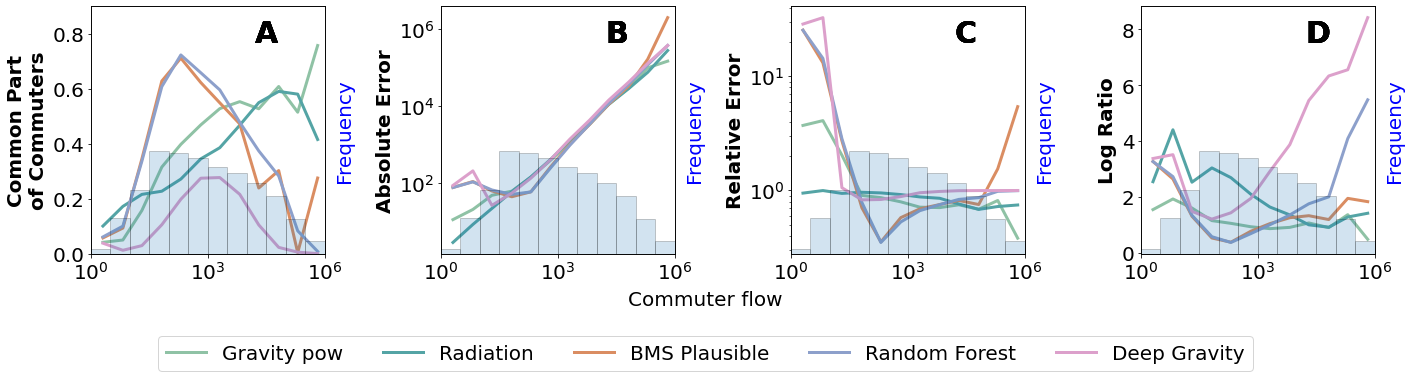

In [10]:
import matplotlib.cm as cm

SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20
#print(_dict,df)
windows=np.array([1,3,10,30,100,300,1e3,3e3,1e4,3e4,1e5,3e5,1e6,3e6])
models=['Gravity pow','Radiation','BMS Plausible','Random Forest','Deep Gravity']
#models=['BMS Plausible','BMS Ensemble','BMS Predictive','Deep Gravity']

metrics=['CPC','AbsErr','RE','LogRatio']
size=(20, 20)
#print(metric,model)
colors=[[i/255. for i in color_dict[key]]+[1] for key in models]
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

chars='ABCDE'

fig, axs = plt.subplots(1,len(metrics),figsize=(20,5))
for i,m in enumerate(metrics):
    for l,model in enumerate(models):
        #print(m)
        data={'test':[],model:[],'testDG':[],'Deep Gravity':[]}
        for j,s in enumerate(states):
            # Get de value for each model
            data['test']=[*data['test'],*scatter_models_C_final[s]['test']]
            data[model]=[*data[model],*scatter_models_C_final[s][model]]
            data['testDG']=[*data['testDG'],*scatter_models_C_final[s]['testDG']]
            data['Deep Gravity']=[*data['Deep Gravity'],*scatter_models_C_final[s]['Deep Gravity']]
        res=[]
        num_points=[]
        for k in range(0,len(windows)-1):
            # Select flows in range
            #print(windows[k],windows[k+1])
            if l==0: num_points.append(len([point for point in data['test'] if windows[k]<point<windows[k+1]]))
            if model=='Deep Gravity':
                aux=metric_functions[i](data['testDG'],data['Deep Gravity'],windows[k],windows[k+1])
            else:
                aux=metric_functions[i](data['test'],data[model],windows[k],windows[k+1])

            if m=='CPC':
                res.append(aux)
                axs[i].set_ylabel('Common Part\nof Commuters', fontweight="bold")
                axs[i].set_ylim([0,0.9])
            else:
                res.append(np.median(aux))
        #print(windows[0:len(res)]+windows[1:len(res)+1]/2.)
        axs[i].text(.7, .95,chars[i], ha='left', va='top',size=30, transform=axs[i].transAxes, weight='bold')
        axs[i].plot((windows[0:len(res)]+windows[1:len(res)+1])/2.,res, color=colors[l],label=model,lw=3.)
        axs[i].set_xscale('log')
        axs[i].set_xlim([1,1e6])
        if m=='RE':
            axs[i].set_ylabel('Relative Error', fontweight="bold")
        elif m=='LogRatio':
            axs[i].set_ylabel('Log Ratio', fontweight="bold")
        elif m=='AbsErr':
            axs[i].set_ylabel('Absolute Error', fontweight="bold")
        if m=='AbsErr' or m=='RE':
            axs[i].set_yscale('log')
        axs[i].set_xlim([1,1e6])
        if l==0:
            #print(windows[:len(res)], num_points, np.diff(windows[:len(res)]))
            #print(len(windows[:len(res)]), len(num_points), len(np.diff(windows[:len(res)+1])))
            tx = axs[i].twinx()
            tx.bar(windows[:len(res)], num_points, log=True,ec="k", align="edge", alpha=0.2, width=np.diff(windows[:len(res)+1]))
            tx.set_ylim([0,1e10])
            tx.set_xlim([1,1e6])
            tx.set_xticks([])
            tx.set_yticks([])
            tx.set_ylabel('Frequency',labelpad=10.)
            tx.yaxis.label.set_color('b')
lines, labels = axs[0].get_legend_handles_labels()
print(lines, labels)
#lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels,loc='lower center',ncol=len(models),bbox_to_anchor=(0.5, -0.1))
fig.supxlabel('Commuter flow',x=0.5,y=0.1)
fig.tight_layout()
fig.show()
#fig.savefig('./Plots/week1_metrics_merged.pdf',bbox_inches='tight',dpi=300)

In [11]:
import traceback
name=open('./data/checkpoints/fold2_dataframes_2022_11_02-02_54_03.pkl', "rb")
test=pickle.load(name)
name.close()

name=open('./data/checkpoints/scatter_C_2023_07_20-07_56_07.pkl', "rb")
scatter_models_C_final=pickle.load(name)
name.close()

test_DG_week2={state:0 for state in scatter_models_C_final.keys()}


scatter_models_C_final_mod={state:{model:[] for model in scatter_models_C_final[state].keys() } for state in scatter_models_C_final.keys()}
print(scatter_models_C_final_mod)

#
state='New York'
week2=pd.read_pickle('data/NewYork/city_trips_features_2023_04_26-08_27_34.pkl')
#scatter_models_C_final_mod[state]['test']=[]
for i,row in enumerate(test[state].iterrows()):
    try:
        #print(i)
        flow_second_week = week2[(week2.name_o==row[1].name_o)&(week2.name_d==row[1].name_d)].total_pop_flow.values.tolist()[0]
        #print('f',flow_second_week)
        if flow_second_week>0:
            scatter_models_C_final_mod[state]['test'].append(flow_second_week)
            for model in [m for m in scatter_models_C_final[state].keys() if m not in ['test','testDG','Deep Gravity']]:
                try:
                    val=scatter_models_C_final[state][model].iloc[i]
                except Exception as e:
                    val=scatter_models_C_final[state][model][i]
                scatter_models_C_final_mod[state][model].append(val)
            if type(test_DG_week2[state])==type(0):
                test_DG_week2[state]=week2[(week2.name_o==row[1].name_o)&(week2.name_d==row[1].name_d)]
            else:
                test_DG_week2[state]=test_DG_week2[state].append(week2[(week2.name_o==row[1].name_o)&(week2.name_d==row[1].name_d)],ignore_index=True)
            
    except Exception as e:
        pass
        #print(e,traceback.print_exc())
        #print(row[1],week2[(week2.name_o==row[1].name_o)&(week2.name_d==row[1].name_d)].total_pop_flow)
print({model:len(scatter_models_C_final_mod[state][model]) for model in scatter_models_C_final_mod[state].keys()})
print(len(test_DG_week2[state]))
#print(scatter_models_C_final_mod[state]['test'])
#
state='Massachusetts'
week2=pd.read_pickle('data/Massachusetts/city_trips_features_2023_04_26-02_24_00.pkl')
for i,row in enumerate(test[state].iterrows()):
    try:
        #print(i)
        flow_second_week = week2[(week2.name_o==row[1].name_o)&(week2.name_d==row[1].name_d)].total_pop_flow.values.tolist()[0]
        #print('f',flow_second_week)
        if flow_second_week>0:
            scatter_models_C_final_mod[state]['test'].append(flow_second_week)
            for model in [m for m in scatter_models_C_final[state].keys() if m not in ['test','testDG','Deep Gravity']]:
                try:
                    val=scatter_models_C_final[state][model].iloc[i]
                except Exception as e:
                    val=scatter_models_C_final[state][model][i]
                scatter_models_C_final_mod[state][model].append(val)
            if type(test_DG_week2[state])==type(0):
                test_DG_week2[state]=week2[(week2.name_o==row[1].name_o)&(week2.name_d==row[1].name_d)]
            else:
                test_DG_week2[state]=test_DG_week2[state].append(week2[(week2.name_o==row[1].name_o)&(week2.name_d==row[1].name_d)],ignore_index=True)
            
    except Exception as e:
        pass
state='California'
week2=pd.read_pickle('data/California/city_trips_features_2023_04_28-10_15_22.pkl')
for i,row in enumerate(test[state].iterrows()):
    try:
        #print(i)
        flow_second_week = week2[(week2.name_o==row[1].name_o)&(week2.name_d==row[1].name_d)].total_pop_flow.values.tolist()[0]
        #print('f',flow_second_week)
        if flow_second_week>0:
            scatter_models_C_final_mod[state]['test'].append(flow_second_week)
            for model in [m for m in scatter_models_C_final[state].keys() if m not in ['test','testDG','Deep Gravity']]:
                try:
                    val=scatter_models_C_final[state][model].iloc[i]
                except Exception as e:
                    val=scatter_models_C_final[state][model][i]
                scatter_models_C_final_mod[state][model].append(val)
            if type(test_DG_week2[state])==type(0):
                test_DG_week2[state]=week2[(week2.name_o==row[1].name_o)&(week2.name_d==row[1].name_d)]
            else:
                test_DG_week2[state]=test_DG_week2[state].append(week2[(week2.name_o==row[1].name_o)&(week2.name_d==row[1].name_d)],ignore_index=True)
            
    except Exception as e:
        pass
state='Florida'
week2=pd.read_pickle('data/Florida/city_trips_features_2023_04_29-08_50_13.pkl')
for i,row in enumerate(test[state].iterrows()):
    try:
        #print(i)
        flow_second_week = week2[(week2.name_o==row[1].name_o)&(week2.name_d==row[1].name_d)].total_pop_flow.values.tolist()[0]
        #print('f',flow_second_week)
        if flow_second_week>0:
            scatter_models_C_final_mod[state]['test'].append(flow_second_week)
            for model in [m for m in scatter_models_C_final[state].keys() if m not in ['test','testDG','Deep Gravity']]:
                try:
                    val=scatter_models_C_final[state][model].iloc[i]
                except Exception as e:
                    val=scatter_models_C_final[state][model][i]
                scatter_models_C_final_mod[state][model].append(val)
            if type(test_DG_week2[state])==type(0):
                test_DG_week2[state]=week2[(week2.name_o==row[1].name_o)&(week2.name_d==row[1].name_d)]
            else:
                test_DG_week2[state]=test_DG_week2[state].append(week2[(week2.name_o==row[1].name_o)&(week2.name_d==row[1].name_d)],ignore_index=True)
            
    except Exception as e:
        pass
state='Texas'
week2=pd.read_pickle('data/Texas/city_trips_features_2023_04_30-05_26_25.pkl')
for i,row in enumerate(test[state].iterrows()):
    try:
        #print(i)
        flow_second_week = week2[(week2.name_o==row[1].name_o)&(week2.name_d==row[1].name_d)].total_pop_flow.values.tolist()[0]
        #print('f',flow_second_week)
        if flow_second_week>0:
            scatter_models_C_final_mod[state]['test'].append(flow_second_week)
            for model in [m for m in scatter_models_C_final[state].keys() if m not in ['test','testDG','Deep Gravity']]:
                try:
                    val=scatter_models_C_final[state][model].iloc[i]
                except Exception as e:
                    val=scatter_models_C_final[state][model][i]
                scatter_models_C_final_mod[state][model].append(val)
            if type(test_DG_week2[state])==type(0):
                test_DG_week2[state]=week2[(week2.name_o==row[1].name_o)&(week2.name_d==row[1].name_d)]
            else:
                test_DG_week2[state]=test_DG_week2[state].append(week2[(week2.name_o==row[1].name_o)&(week2.name_d==row[1].name_d)],ignore_index=True)
            
    except Exception as e:
        pass
state='Washington'
week2=pd.read_pickle('data/Washington/city_trips_features_2023_04_29-04_33_02.pkl')
for i,row in enumerate(test[state].iterrows()):
    try:
        #print(i)
        flow_second_week = week2[(week2.name_o==row[1].name_o)&(week2.name_d==row[1].name_d)].total_pop_flow.values.tolist()[0]
        #print('f',flow_second_week)
        if flow_second_week>0:
            scatter_models_C_final_mod[state]['test'].append(flow_second_week)
            for model in [m for m in scatter_models_C_final[state].keys() if m not in ['test','testDG','Deep Gravity']]:
                try:
                    val=scatter_models_C_final[state][model].iloc[i]
                except Exception as e:
                    val=scatter_models_C_final[state][model][i]
                scatter_models_C_final_mod[state][model].append(val)
            if type(test_DG_week2[state])==type(0):
                test_DG_week2[state]=week2[(week2.name_o==row[1].name_o)&(week2.name_d==row[1].name_d)]
            else:
                test_DG_week2[state]=test_DG_week2[state].append(week2[(week2.name_o==row[1].name_o)&(week2.name_d==row[1].name_d)],ignore_index=True)
            
    except Exception as e:
        pass
with open('./data/checkpoints/test_DG_week2.pkl', 'wb') as handle:
    pickle.dump(test_DG_week2, handle, protocol=pickle.HIGHEST_PROTOCOL)

<class 'NoneType'>
{'New York': {'Random Forest': [], 'test': [], 'Deep Gravity': [], 'testDG': [], 'Radiation': [], 'Gravity pow': [], 'Gravity exp': [], 'BMS Plausible': [], 'BMS Ensemble': [], 'BMS-MuDF(ens,best)': [], 'BMS Predictive': [], 'BMS-MuDF(ens,best ae)': []}, 'Massachusetts': {'Random Forest': [], 'test': [], 'Deep Gravity': [], 'testDG': [], 'Radiation': [], 'Gravity pow': [], 'Gravity exp': [], 'BMS Plausible': [], 'BMS Ensemble': [], 'BMS-MuDF(ens,best)': [], 'BMS Predictive': [], 'BMS-MuDF(ens,best ae)': []}, 'California': {'Random Forest': [], 'test': [], 'Deep Gravity': [], 'testDG': [], 'Radiation': [], 'Gravity pow': [], 'Gravity exp': [], 'BMS Plausible': [], 'BMS Ensemble': [], 'BMS-MuDF(ens,best)': [], 'BMS Predictive': [], 'BMS-MuDF(ens,best ae)': []}, 'Florida': {'Random Forest': [], 'test': [], 'Deep Gravity': [], 'testDG': [], 'Radiation': [], 'Gravity pow': [], 'Gravity exp': [], 'BMS Plausible': [], 'BMS Ensemble': [], 'BMS-MuDF(ens,best)': [], 'BMS Predi

In [12]:
res={}
files={'New York':""}
list_week1=pd.read_pickle('data/checkpoints/list_states_dataframes_2022_11_02-02_53_58.pkl')
list_week2=[
pd.read_pickle('data/NewYork/city_trips_features_2023_04_26-08_27_34.pkl'),
pd.read_pickle('data/Massachusetts/city_trips_features_2023_04_26-02_24_00.pkl'),
pd.read_pickle('data/California/city_trips_features_2023_04_28-10_15_22.pkl'),
pd.read_pickle('data/Florida/city_trips_features_2023_04_29-08_50_13.pkl'),
pd.read_pickle('data/Washington/city_trips_features_2023_04_29-04_33_02.pkl'),
pd.read_pickle('data/Texas/city_trips_features_2023_04_30-05_26_25.pkl'),
]
for i,key in enumerate(states):

    if key=='New York':
        name='NewYork'
    else:
        name=key
    df=pd.read_pickle(f'./DeepGravity/results_week2/fluxos_DG_{name}.pkl')
    display(df)
    
    test_labels=[]
    predictions=[]
    for row in df.iterrows():
        origin=row[1].name
        out_week1=np.sum(list_week1[i][list_week1[i].name_o==origin].total_pop_flow.values)
        out_week2=np.sum(list_week2[i][list_week2[i].name_o==origin].total_pop_flow.values)
        for l,m in zip(row[1].data,row[1].target):
            if l>0.0:
                test_labels.append(l)
                predictions.append(m*(out_week1/out_week2))
    print(max(test_labels),max(predictions))
    print(len(test_labels),len(predictions))
    print(len(scatter_models_C_final_mod[key]['test']))
    scatter_models_C_final_mod[key]['Deep Gravity']=deepcopy(predictions)
    scatter_models_C_final_mod[key]['testDG']=deepcopy(test_labels)

,data,target
Altamont,"[1213.0, 0.0, 0.0, 544.0, 99.0, 0.0, 1164.0]","[1777.6912, 40.350056, 42.485893, 942.33875, 2..."
Lockport,"[0.0, 0.0, 0.0, 0.0, 0.0, 1340.0, 0.0, 0.0, 0....","[19.408123, 33.44643, 770.7282, 11.548255, 241..."
Head of the Harbor,"[1220.0, 207.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[260.4501, 125.04076, 847.7981, 138.61894, 2.1..."
Islandia,"[520.0, 0.0, 0.0, 49.0, 0.0, 0.0, 0.0, 0.0, 0....","[68.85336, 520.481, 13.705792, 5.013209, 15.33..."
Lake Grove,"[677.0, 133.0, 136.0, 0.0, 0.0, 0.0, 199.0, 0....","[214.81747, 29.792576, 23.805687, 3.3633068, 1..."
...,...,...
Woodmere,"[0.0, 0.0, 73.0, 0.0, 919.0, 1578.0, 78.0, 0.0...","[45.16743, 63.959496, 41.51989, 67.18655, 1050..."
Wyandanch,"[146.0, 50.0, 387.0, 200.0, 0.0, 0.0, 146.0, 0...","[39.484222, 31.389301, 504.9419, 55.650936, 19..."
Yaphank,"[743.0, 559.0, 132.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[71.86731, 189.17485, 32.903828, 43.470634, 32..."
University Gardens,"[0.0, 2289.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[126.66872, 924.62476, 1268.7107, 14.455902, 3..."


35063.0 14847.33942034372
3922 3922
3922


,data,target
Southbridge Town,"[69.0, 0.0, 0.0, 0.0, 91.0, 0.0, 7592.0, 358.0...","[285.82062, 161.13171, 186.32642, 1611.41, 57...."
Gardner,"[0.0, 0.0, 6142.0, 0.0, 0.0, 231.0, 0.0, 0.0, ...","[43.542538, 111.609474, 2253.8496, 40.897408, ..."
Fitchburg,"[0.0, 2526.0, 0.0, 228.0, 0.0, 0.0, 221.0, 0.0...","[98.48641, 1734.412, 114.382515, 320.1748, 87...."
Winthrop Town,"[0.0, 194.0, 0.0, 0.0, 1130.0, 0.0, 2970.0, 11...","[329.53595, 76.710396, 986.0204, 304.03864, 32..."
Framingham,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 809.0...","[9.065063, 6.6354985, 48.95265, 43.62271, 9.37..."
...,...,...
Whitinsville,"[0.0, 431.0, 0.0, 0.0, 2775.0, 0.0, 0.0, 0.0, ...","[55.666504, 299.75842, 655.5691, 210.6836, 152..."
Wilbraham,"[0.0, 0.0, 0.0, 0.0, 72.0, 0.0, 0.0, 0.0, 144....","[29.130096, 291.58316, 2.8653445, 158.69124, 9..."
Williamstown,"[0.0, 0.0, 1574.0, 0.0]","[24.338228, 1282.2616, 262.64673, 4.753306]"
Wilmington,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 451.0, 0.0, 0.0...","[47.172333, 24.928473, 46.007988, 283.3989, 79..."


55499.0 21408.54933681672
808 808
808


,data,target
Anaheim,"[0.0, 45290.0, 0.0, 0.0, 0.0, 79930.0, 0.0, 22...","[14148.605, 9190.941, 29210.652, 21072.998, 11..."
Cypress,"[20049.0, 0.0, 0.0, 0.0, 0.0, 2789.0, 0.0, 76....","[16599.129, 1056.353, 8956.28, 7502.411, 71.85..."
Orange,"[60614.0, 0.0, 1978.0, 0.0, 0.0, 0.0, 0.0, 668...","[23971.47, 2363.3042, 1771.6536, 5016.933, 312..."
San Juan Capistrano,"[3698.0, 0.0, 0.0, 0.0, 0.0, 1293.0, 5788.0, 1...","[767.42633, 307.34882, 115.93938, 89.83694, 69..."
Santa Ana,"[85499.0, 0.0, 3335.0, 0.0, 0.0, 0.0, 58550.0,...","[30222.902, 35679.703, 2279.6125, 10151.182, 2..."
...,...,...
West Carson,"[432.0, 0.0, 83.0, 0.0, 0.0, 116.0, 200.0, 0.0...","[231.17313, 21.326069, 21.539562, 52.67519, 25..."
Westmont,"[668.0, 0.0, 0.0, 0.0, 0.0, 0.0, 177.0, 61.0, ...","[524.36365, 42.79888, 51.70382, 138.74736, 57...."
West Puente Valley,"[818.0, 0.0, 0.0, 0.0, 0.0, 186.0, 0.0, 0.0, 0...","[2262.9954, 637.6464, 51.122578, 123.170525, 3..."
Winter Gardens,"[141.0, 0.0, 0.0, 443.0, 899.0, 0.0, 6254.0, 0...","[14.377311, 2.3335533, 2.9389436, 18.352219, 5..."


416696.0 544457.5597467521
7260 7260
7260


,data,target
Lantana,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[847.52203, 10.684292, 71.00041, 129.04495, 15..."
Avon Park,"[0.0, 0.0, 0.0, 537.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[2.925523, 6.840758, 4.4118886, 178.8052, 4.87..."
Jacksonville Beach,"[0.0, 4897.0, 0.0, 132.0, 0.0, 0.0, 0.0, 310.0...","[1581.7577, 2371.0247, 92.05421, 26.2684, 2.01..."
Neptune Beach,"[0.0, 7906.0, 0.0, 0.0, 0.0, 0.0, 0.0, 47.0, 1...","[395.7963, 4547.453, 92.68339, 24.463053, 2.83..."
Port Richey,"[111.0, 849.0, 0.0, 0.0, 366.0, 639.0, 273.0, ...","[89.77275, 259.85004, 23.153345, 74.945015, 13..."
...,...,...
Westchester,"[0.0, 0.0, 587.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41....","[19.857172, 8.96876, 105.67238, 124.27179, 39...."
Westgate,"[225.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 51....","[112.71005, 2544.4316, 6.747257, 623.58966, 29..."
West Samoset,"[0.0, 0.0, 289.0, 0.0, 530.0, 0.0, 193.0, 0.0,...","[5.047923, 624.48517, 118.135925, 15.990028, 8..."
Willow Oak,"[0.0, 0.0, 229.0, 0.0, 0.0, 0.0, 823.0, 0.0, 0...","[2.9126143, 2.9677432, 55.540215, 2037.9572, 2..."


79624.0 195600.2852376378
4550 4550
4550


,data,target
Clarkston,"[61.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[2.3478022, 0.75109637, 4.0911, 0.08805424, 0...."
Tumwater,"[0.0, 307.0, 2350.0, 0.0, 72.0, 216.0, 0.0, 0....","[42.502148, 37.939598, 278.3543, 361.50818, 25..."
Pasco,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 271.0, 0.0, 0.0...","[1.5084791, 960.35913, 42.441013, 23.742926, 1..."
Centralia,"[0.0, 143.0, 323.0, 0.0, 86.0, 0.0, 0.0, 0.0, ...","[123.87751, 228.84515, 102.78522, 162.9609, 78..."
Chehalis,"[0.0, 85.0, 256.0, 0.0, 0.0, 340.0, 0.0, 0.0, ...","[96.10706, 60.106213, 180.55122, 41.87489, 50...."
...,...,...
Suquamish,"[631.0, 0.0, 101.0, 0.0, 0.0, 0.0, 404.0, 0.0,...","[292.80594, 2207.6997, 70.41778, 192.81471, 9...."
Union Hill-Novelty Hill,"[80.0, 0.0, 0.0, 0.0, 2631.0, 900.0, 0.0, 0.0,...","[378.0402, 76.66816, 405.64432, 44.426792, 829..."
Waller,"[0.0, 0.0, 162.0, 0.0, 1625.0, 0.0, 234.0, 0.0...","[17.471714, 39.695793, 100.36957, 78.31052, 55..."
Wauna,"[0.0, 0.0, 273.0, 91.0, 0.0, 2668.0, 0.0, 5441...","[2.0121312, 64.03034, 419.24963, 74.54844, 348..."


54245.0 91910.63850059149
1393 1393
1393


,data,target
Stafford,"[0.0, 0.0, 0.0, 0.0, 110.0, 0.0, 0.0, 0.0, 166...","[4.482925, 0.039299686, 9.074266, 5.1083455, 1..."
Del Rio,"[0.0, 0.0, 0.0, 0.0, 0.0, 253.0, 0.0, 0.0, 214...","[0.7871768, 10.056299, 0.03371112, 0.19204417,..."
Victoria,"[253.0, 0.0, 60.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.83561933, 0.5528013, 0.4648621, 2.1839333, ..."
Fair Oaks Ranch,"[0.0, 0.0, 0.0, 377.0, 0.0, 0.0, 156.0, 94.0, ...","[13.735642, 10.775318, 134.64601, 197.96866, 1..."
Castle Hills,"[0.0, 0.0, 92.0, 95.0, 138.0, 3.0, 0.0, 0.0, 0...","[2.6815085, 710.11444, 389.6099, 158.4314, 125..."
...,...,...
Potosi,"[0.0, 216.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 302...","[0.02723185, 1.6016675, 1.6291794, 158.92348, ..."
Randolph AFB,"[0.0, 33.0, 0.0, 0.0, 165.0, 1113.0, 0.0, 0.0,...","[137.73447, 132.94736, 12.391322, 144.01584, 9..."
San Pedro,"[0.0, 66.0, 0.0, 0.0, 0.0, 4874.0, 0.0, 0.0, 0...","[1.4931489, 209.83711, 1.8958573, 114.56923, 1..."
Timberwood Park,"[33.0, 0.0, 0.0, 136.0, 35.0, 0.0, 970.0, 0.0,...","[6.1090364, 24.512049, 0.22101349, 22.876434, ..."


112865.0 46025.07682501091
1608 1608
1608


name=open('./repository/data/checkpoints/scatter_C_2023_05_25-07_18_16.pkl', "rb")
scatter_models_C_final_mod=pickle.load(name)
name.close()
name=open('./repository/data/checkpoints/scatter_C_2023_05_23-06_00_21.pkl', "rb")
scatter_models_C_final_mod=pickle.load(name)
name.close()

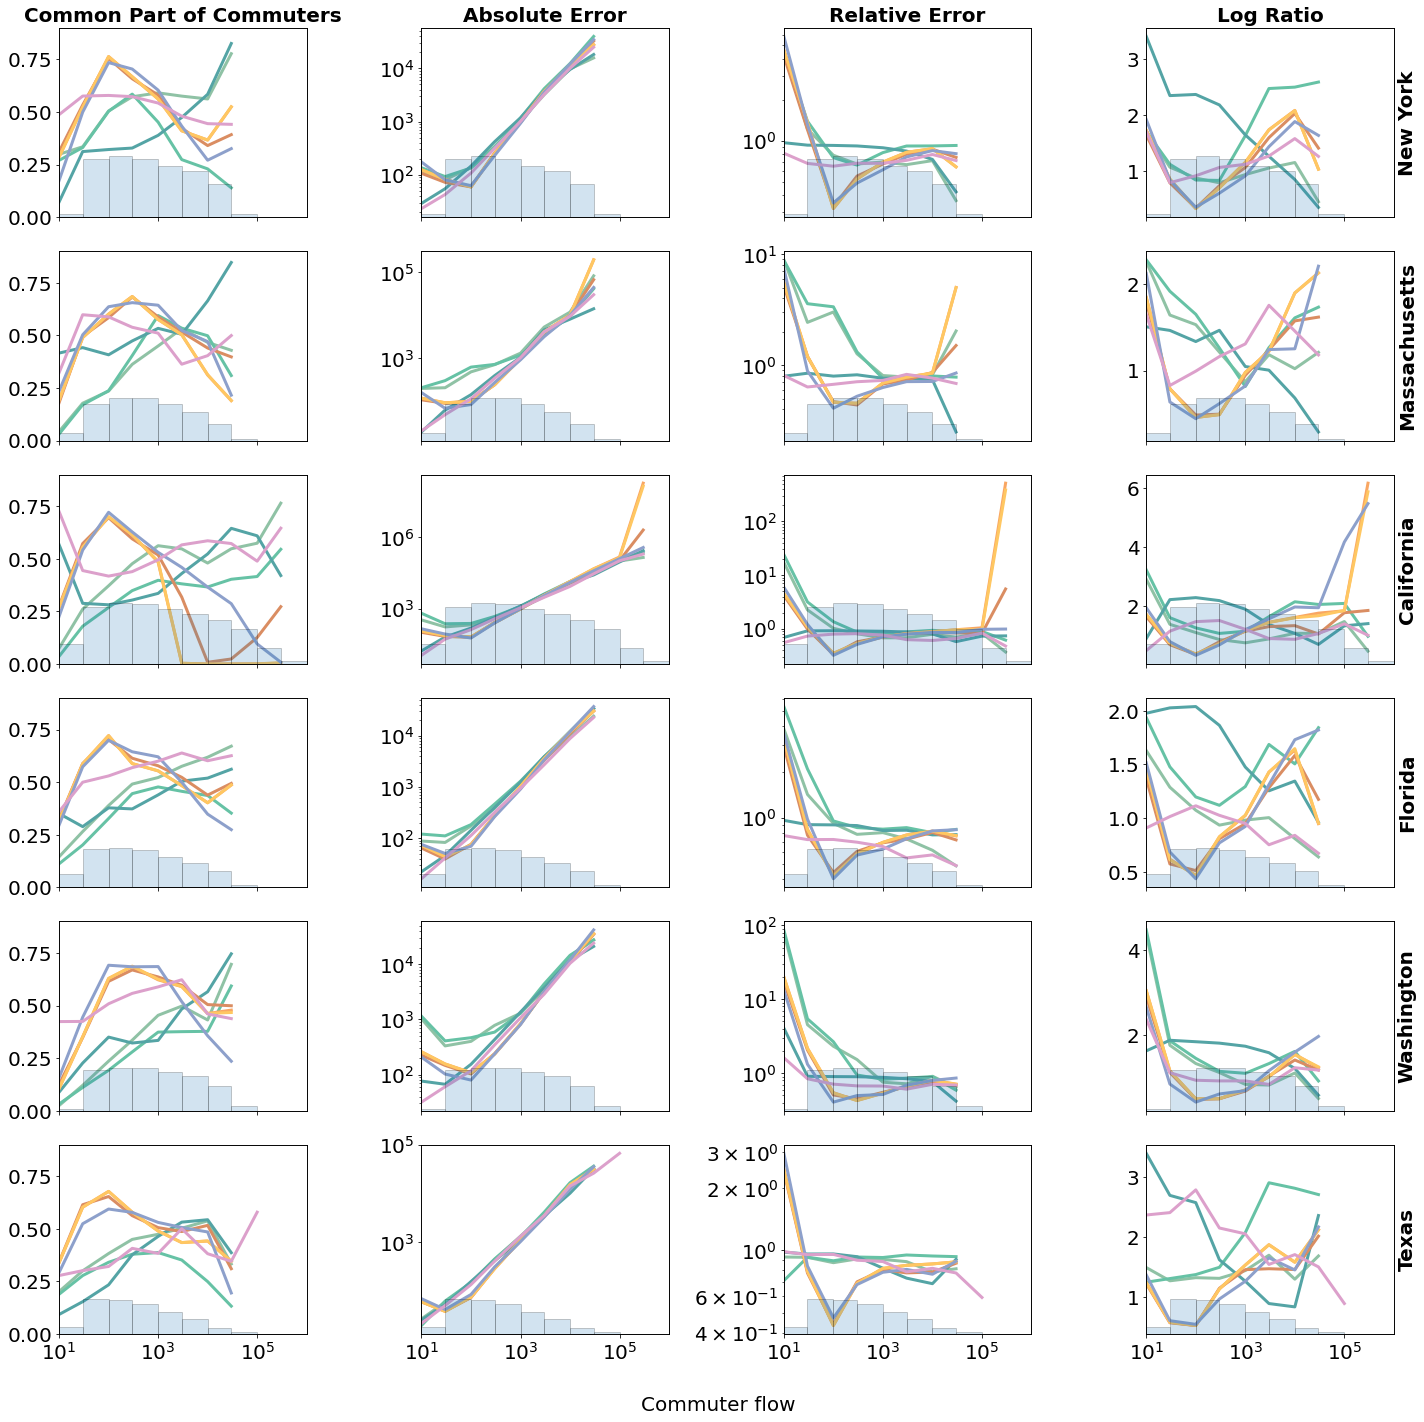

In [14]:
models=['Gravity pow','Gravity exp','Radiation','BMS Plausible','BMS Ensemble','BMS Predictive','Random Forest','Deep Gravity']
#models=['BMS Plausible','BMS Ensemble','BMS Predictive','Deep Gravity']
states=['New York','Massachusetts','California','Florida','Washington','Texas']
metrics=['CPC','AbsErr','RE','LogRatio']
windows=[10,30,100,300,1e3,3e3,1e4,3e4,1e5,3e5,1e6,3e6]
colors=[[i/255. for i in color_dict[key]]+[1] for key in models]
fig, axs = plt.subplots(len(states),len(metrics),figsize=size,sharex='col')
for i,m in enumerate(metrics):
    for j,s in enumerate(states):
        # Get de value for each model
        data=scatter_models_C_final_mod[s]
        for l,model in enumerate(models):
            #print(m)
            res=[]
            bar_values=[]
            num_points=[]
            for k in range(0,len(windows)-1):
                # Select flows in range
                #print(windows[k],windows[k+1])
                if l==0: num_points.append(len([point for point in data['test'] if windows[k]<point<windows[k+1]]))
                if model=='Deep Gravity':
                    aux=metric_functions[i](data['testDG'],data['Deep Gravity'],windows[k],windows[k+1])
                else:
                    aux=metric_functions[i](data['test'],data[model],windows[k],windows[k+1])
                if m=='CPC':
                    res.append(aux)
                    if j==0:
                        axs[j,i].set_title('Common Part of Commuters', fontweight="bold")
                    axs[j,i].set_ylim([0,0.9])
                else:
                    res.append(np.median(aux))
                if m!='CPC':
                    bar_values.append(aux)
            #print(res)
            axs[j,i].plot(windows[:len(res)],res, color=colors[l],lw=3.)
            axs[j,i].set_xscale('log')
            if i==len(metrics)-1:
                axs[j,i].set_ylabel(s, fontweight="bold")
                axs[j,i].yaxis.set_label_position("right")
                #axs[j,i].yaxis.tick_right()
            if j==0 and m=='RE':
                axs[j,i].set_title('Relative Error', fontweight="bold")
            elif j==0 and m=='LogRatio':
                axs[j,i].set_title('Log Ratio', fontweight="bold")
            elif j==0 and m=='AbsErr':
                axs[j,i].set_title('Absolute Error', fontweight="bold")
            if m=='AbsErr' or m=='RE':
                axs[j,i].set_yscale('log')
            if l==0:
                #print(windows[:len(res)], num_points, np.diff(windows[:len(res)]))
                #print(len(windows[:len(res)]), len(num_points), len(np.diff(windows[:len(res)+1])))
                tx = axs[j,i].twinx()
                tx.bar(windows[:len(res)], num_points, log=True,ec="k", align="edge", alpha=0.2, width=np.diff(windows[:len(res)+1]))
                tx.set_ylim([0,1e10])
                tx.set_xticks([])
                tx.set_yticks([])
            axs[j,i].set_xlim([10,1e6])
fig.supxlabel('Commuter flow',va='baseline')
plt.tight_layout()
fig.show()
#fig.savefig('./Plots/week2_metrics_windows.pdf',format='pdf', bbox_inches='tight', dpi=300)

H 132.7992145891433 3 4 (0.001, 100000.0) 831.8555456630443
I 167.32094634655198 6 7 (0.001, 100000.0) 1296.7509272320171
J 186.29437114765818 6 7 (0.001, 100000.0) 1652.2114081079956
K 122.73778440097858 4 5 (0.001, 100000.0) 1013.1139816429632
L 209.64339598508263 6 7 (0.001, 100000.0) 1589.5420909719624
M 85.37859915407091 3 4 (0.001, 100000.0) 714.2840465191682
N 0.5923075114116758 6 7 (1e-05, 500.0) 1.9077556779692846
O 0.5411429205702779 6 7 (1e-05, 500.0) 1.773352077533753
P 0.59290681703567 5 6 (1e-05, 500.0) 1.7050820229804324
Q 0.5927609905686708 3 4 (1e-05, 500.0) 1.7001350560279924
R 0.5842075207521541 3 4 (1e-05, 500.0) 2.3827829867629737
S 0.5997327609227683 4 5 (1e-05, 500.0) 1.794781514897733
T 0.6527221197281841 6 7 (-0.339850171276081, 7.137533561727999) 2.24587082284137
U 0.5826603211067962 6 7 (-0.3398567829191918, 7.137533876568146) 2.2168013510284874
V 0.668255599392571 3 4 (-0.3398653152526994, 7.137534282869742) 2.4122546712411688
W 0.6675577721590893 3 4 (-0.33

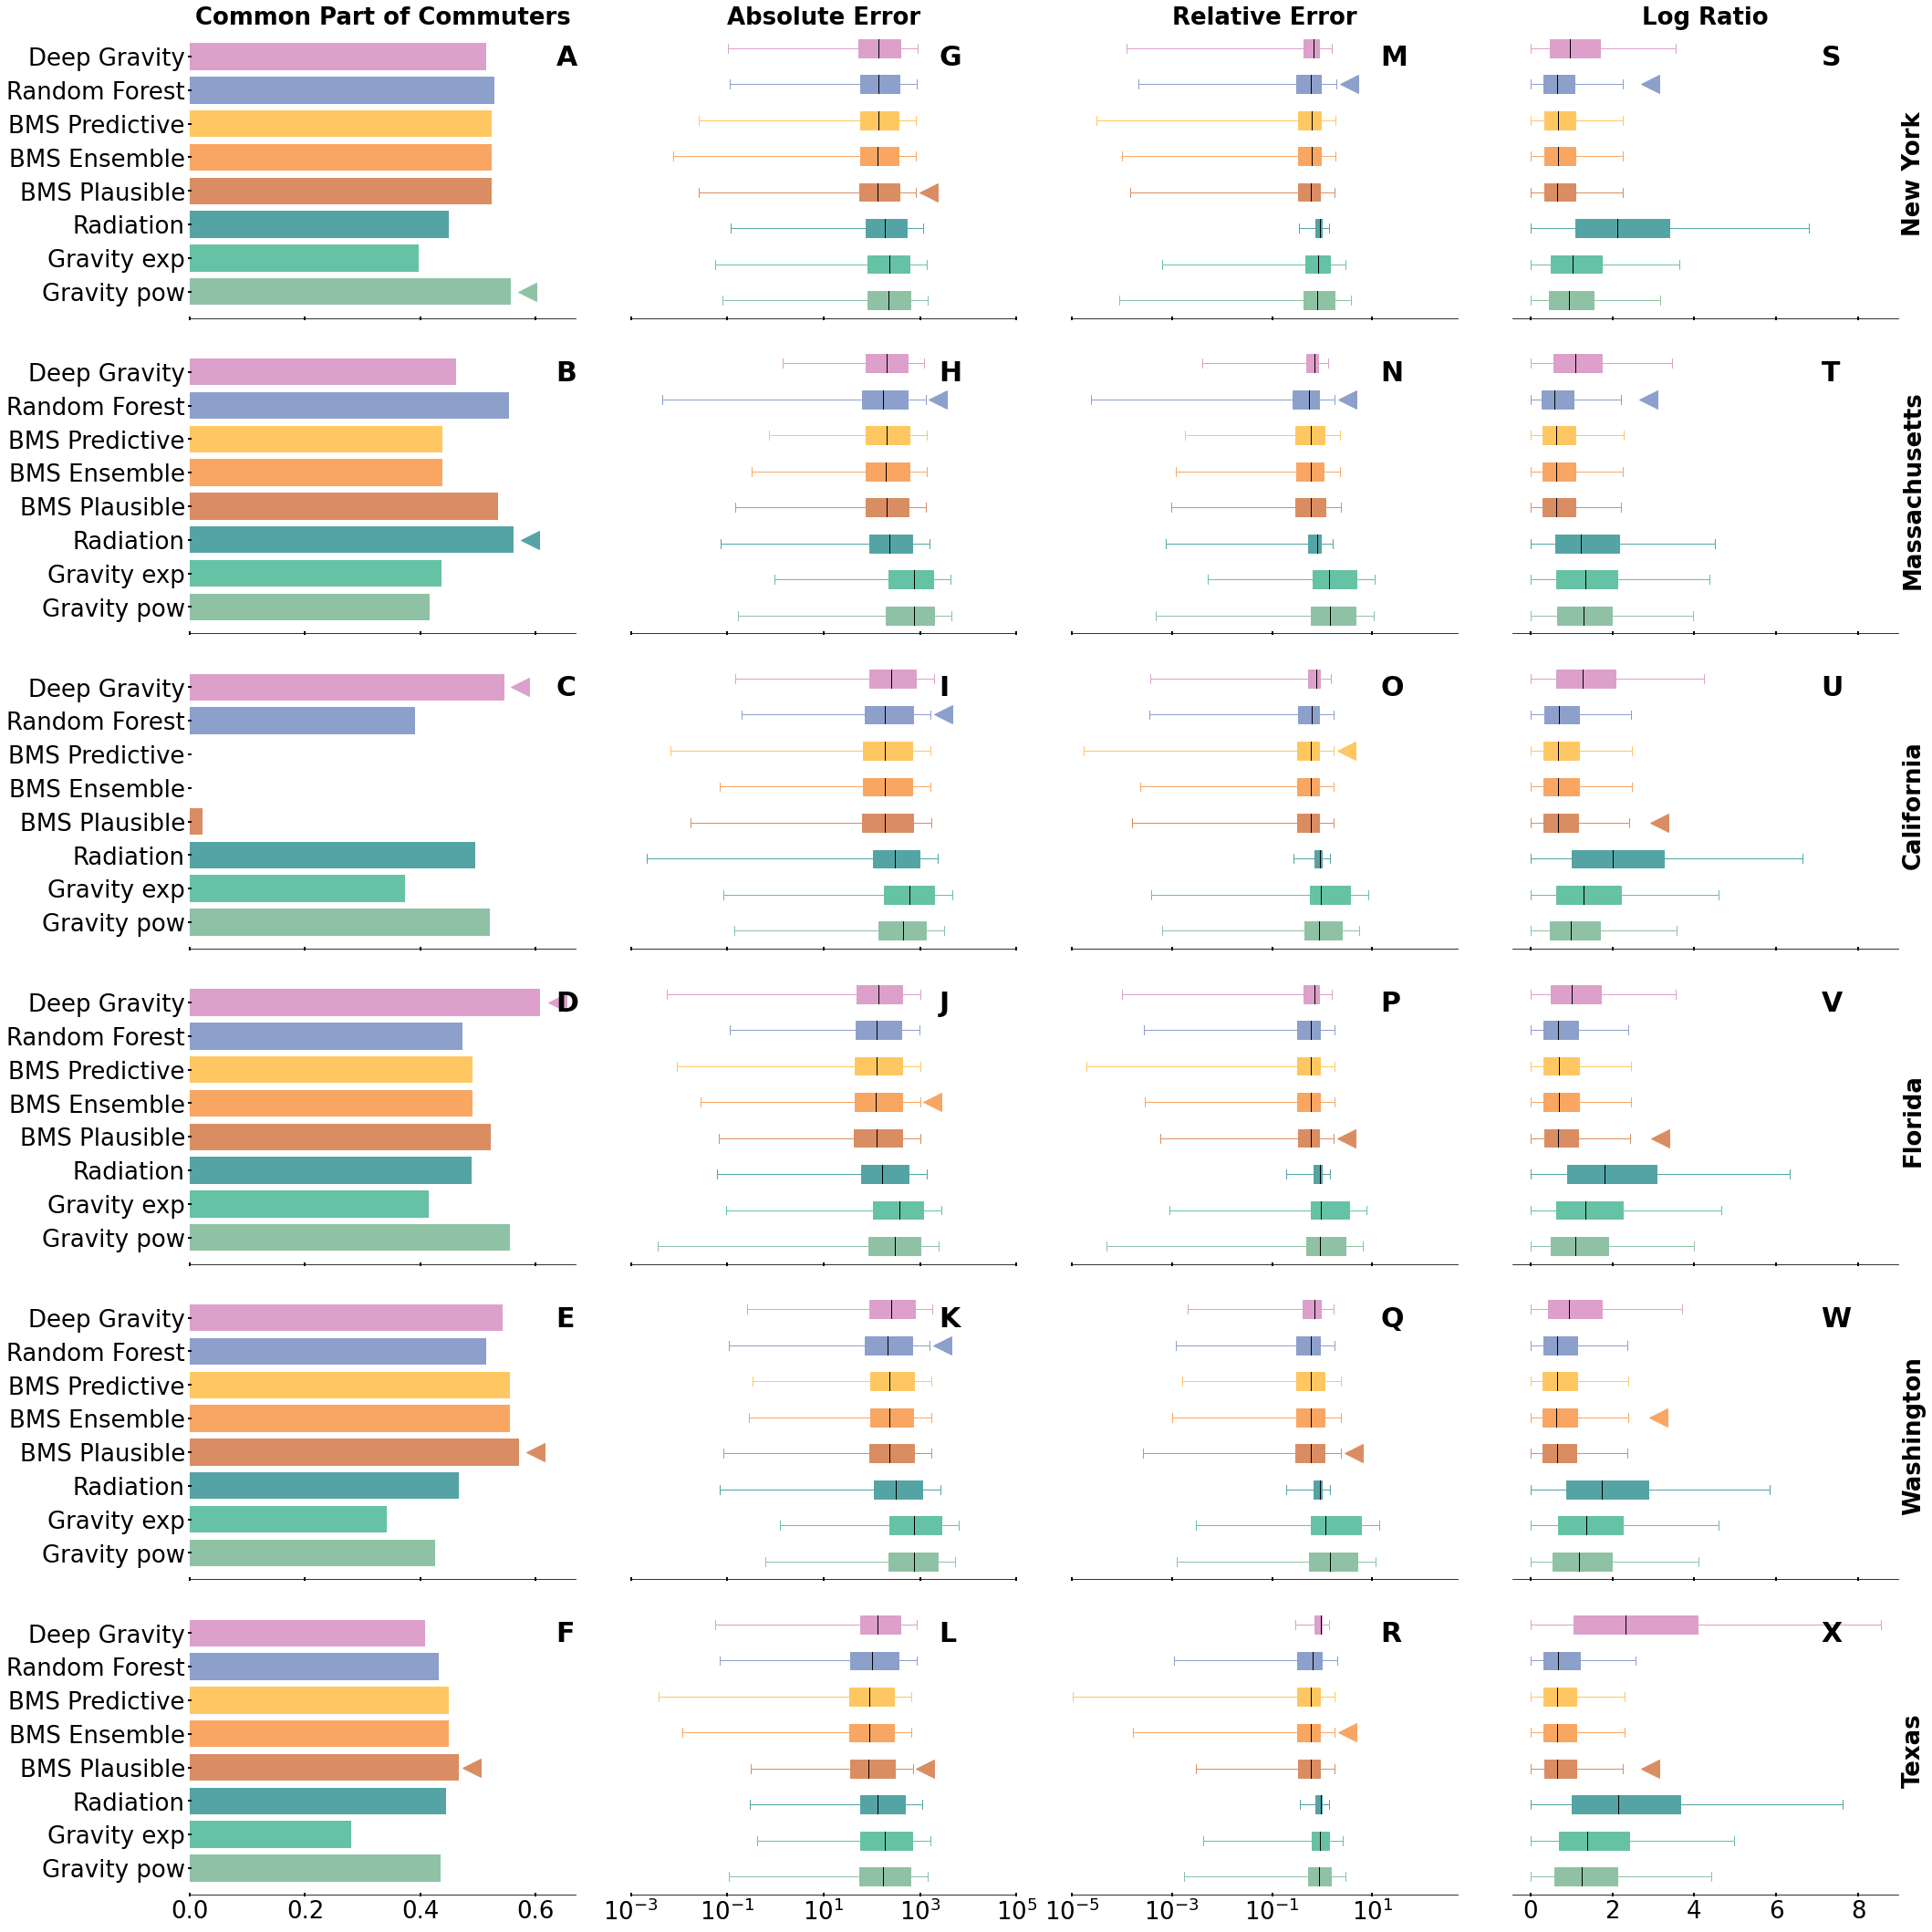

In [17]:
chars='ABCDEFGHIJKLMNOPQRSTUVWXYZ'
SMALL_SIZE = 26
MEDIUM_SIZE = 26
BIGGER_SIZE = 26
def metrics_model_state_h_boxplot(_dict,metric,model,state,size=(30, 30),name=None):
    import matplotlib.cm as cm
    
    SMALL_SIZE = 26
    MEDIUM_SIZE = 26
    BIGGER_SIZE = 26
    #print(_dict,df)
    #print(metric,model)
    colors=[[i/255. for i in color_dict[key]]+[1] for key in model]
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    #sbrn.set(style='ticks', font_scale=2)
    c_count=0
    fig, axs = plt.subplots(len(state),len(metric),figsize=size,sharex='col')
    for i,m in enumerate(metric):
        for j,s in enumerate(state):
            # Get de value for each model
            #print(m)
            data=_dict[s]
            if m=='CPC':
                x=[]
                for mdl in model:
                    try:
                        
                        #cutoff
                    #    if float(df.loc[(mdl,m)][s])<1e5:
                        if mdl=='Deep Gravity':
                            x+=[float(metric_functions[i](data['testDG'],data[mdl],0,1e10))]
                                      
                        else:
                            x+=[float(metric_functions[i](data['test'],data[mdl],0,1e10))]
                    except:
                        x+=[0.]
                # Adding bar plot to final subplot
                ind = np.arange(len(model))
                axs[j,i].barh(ind, x,color=colors)#bar_label(deepcopy(p1), label_type=None)
                if j==0 and m=='CPC':
                    axs[j,i].set_title('Common Part of Commuters', fontweight="bold")
                if i==0: axs[j,i].set_yticks(ind, labels=model)
                axs[j,i].spines.right.set_visible(False)
                axs[j,i].spines.top.set_visible(False)
                axs[j,i].spines.left.set_visible(False)
                axs[j,i].tick_params(direction='inout', width=2)
                axs[j,i].text(.95, .95,chars[c_count], ha='left', va='top',size=30, transform=axs[j,i].transAxes, weight='bold')
                axs[j,i].plot(max(x)+0.05*max(x),x.index(max(x)), marker="<",color=colors[x.index(max(x))], markersize=20)
                c_count+=1
            else:
                x=[]
                for mod in model:
                    if mdl=='Deep Gravity':
                        x.append(metric_functions[i](data['testDG'],data[mod],0,1e10))
                    else:
                        x.append(metric_functions[i](data['test'],data[mod],0,1e10))
                box_dict=axs[j,i].boxplot(x,labels=model,vert=False,showfliers=False,patch_artist=True)
                for item in ['boxes', 'fliers']:
                    for sub_item,color in zip(box_dict[item], colors):
                        plt.setp(sub_item, color=color)
                for item in ['medians']:
                    for sub_item,color in zip(box_dict[item], colors):
                        plt.setp(sub_item, color='black')
                for item in ['means']:
                    for sub_item,color in zip(box_dict[item], colors):
                        sub_item.set_color('black')
                # whiskers and caps have to be treated separately since there are two of each for each plot
                for item in ['whiskers', 'caps']:
                    for sub_items,color in zip(zip(box_dict[item][::2],box_dict[item][1::2]),colors):
                        plt.setp(sub_items, color=color)
                if i==len(metric)-1:
                    axs[j,i].set_ylabel(s, fontweight="bold")
                    axs[j,i].yaxis.set_label_position("right")
                    #axs[j,i].yaxis.tick_right()
                if j==0 and m=='RE':
                    axs[j,i].set_title('Relative Error', fontweight="bold")
                elif j==0 and m=='LogRatio':
                    axs[j,i].set_title('Log Ratio', fontweight="bold")
                elif j==0 and m=='AbsErr':
                    axs[j,i].set_title('Absolute Error', fontweight="bold")
                if i!=0:
                    axs[j,i].set_yticks([])
                ind = np.arange(len(model))+1
                if i==0: axs[j,i].set_yticks(ind, labels=model)
                axs[j,i].spines.right.set_visible(False)
                axs[j,i].spines.top.set_visible(False)
                axs[j,i].spines.left.set_visible(False)
                axs[j,i].tick_params(direction='inout', width=2)
                if m=='RE':
                    axs[j,i].set_xlim([1e-5,5e2])
                if m=='AbsErr':
                    axs[j,i].set_xlim([1e-3,1e5])
                    
                #    axs[j,i].text(.1, .95,chars[c_count], ha='left', va='top',size=30, transform=axs[j,i].transAxes, weight='bold')
                #elif m=='LogRatio':
                #    axs[j,i].text(.8, .95,chars[c_count], ha='left', va='top',size=30, transform=axs[j,i].transAxes, weight='bold')
                #else:
                axs[j,i].text(.8, .95,chars[c_count], ha='left', va='top',size=30, transform=axs[j,i].transAxes, weight='bold')
                c_count+=1
                if m=='RE' or m=='AbsErr':
                    axs[j,i].set_xscale('log')
                high_median=1e10
                high_model=0
                for k,mod in enumerate(model):
                    #print([k.get_xdata() for k in box_dict['caps']])
                    #print(box_dict)
                    if box_dict['medians'][k].get_xdata()[0]<high_median:
                        high_median=box_dict['medians'][k].get_xdata()[0]
                        high_model=k
                        high_model_y=round(box_dict['medians'][k].get_ydata()[0])
                        high_model_caps=box_dict['caps'][2*k+1].get_xdata()[0]
                        x_lims=axs[j,i].get_xlim()
                print(chars[c_count],high_median,high_model,high_model_y,x_lims,high_model_caps)
                #axs[j,i].plot(high_model_caps +0.05*high_model_caps,high_model_y, marker="^",transform=axs[j,i].get_yaxis_transform(),color=colors[high_model], markersize=20)
                if m=='RE' or m=='AbsErr':
                    x_marker=high_model_caps +0.8*high_model_caps
                else:
                    x_marker=high_model_caps +0.3*high_model_caps
                axs[j,i].plot(x_marker,high_model_y, marker="<",color=colors[high_model], markersize=20)
                
    plt.tight_layout()
    #if name!=None:
        #fig.savefig(name,format='pdf')
    fig.show()
    
    #return fig
#p.metrics_model_state_h(df_C_final,['CPC','RMSE','RE','LR'],['Gravity pow','Gravity exp','Radiation','BMS Best','BMS Ensemble','BMS Predictive','Random Forest'],states) #a['NewYork','Massachusetts','Florida','Washington','Texas'])
metrics_model_state_h_boxplot(scatter_models_C_final_mod,['CPC','AbsErr','RE','LogRatio'],['Gravity pow','Gravity exp','Radiation','BMS Plausible','BMS Ensemble','BMS Predictive','Random Forest','Deep Gravity'],states,name='./Plots/week2_error_boxplot.pdf')

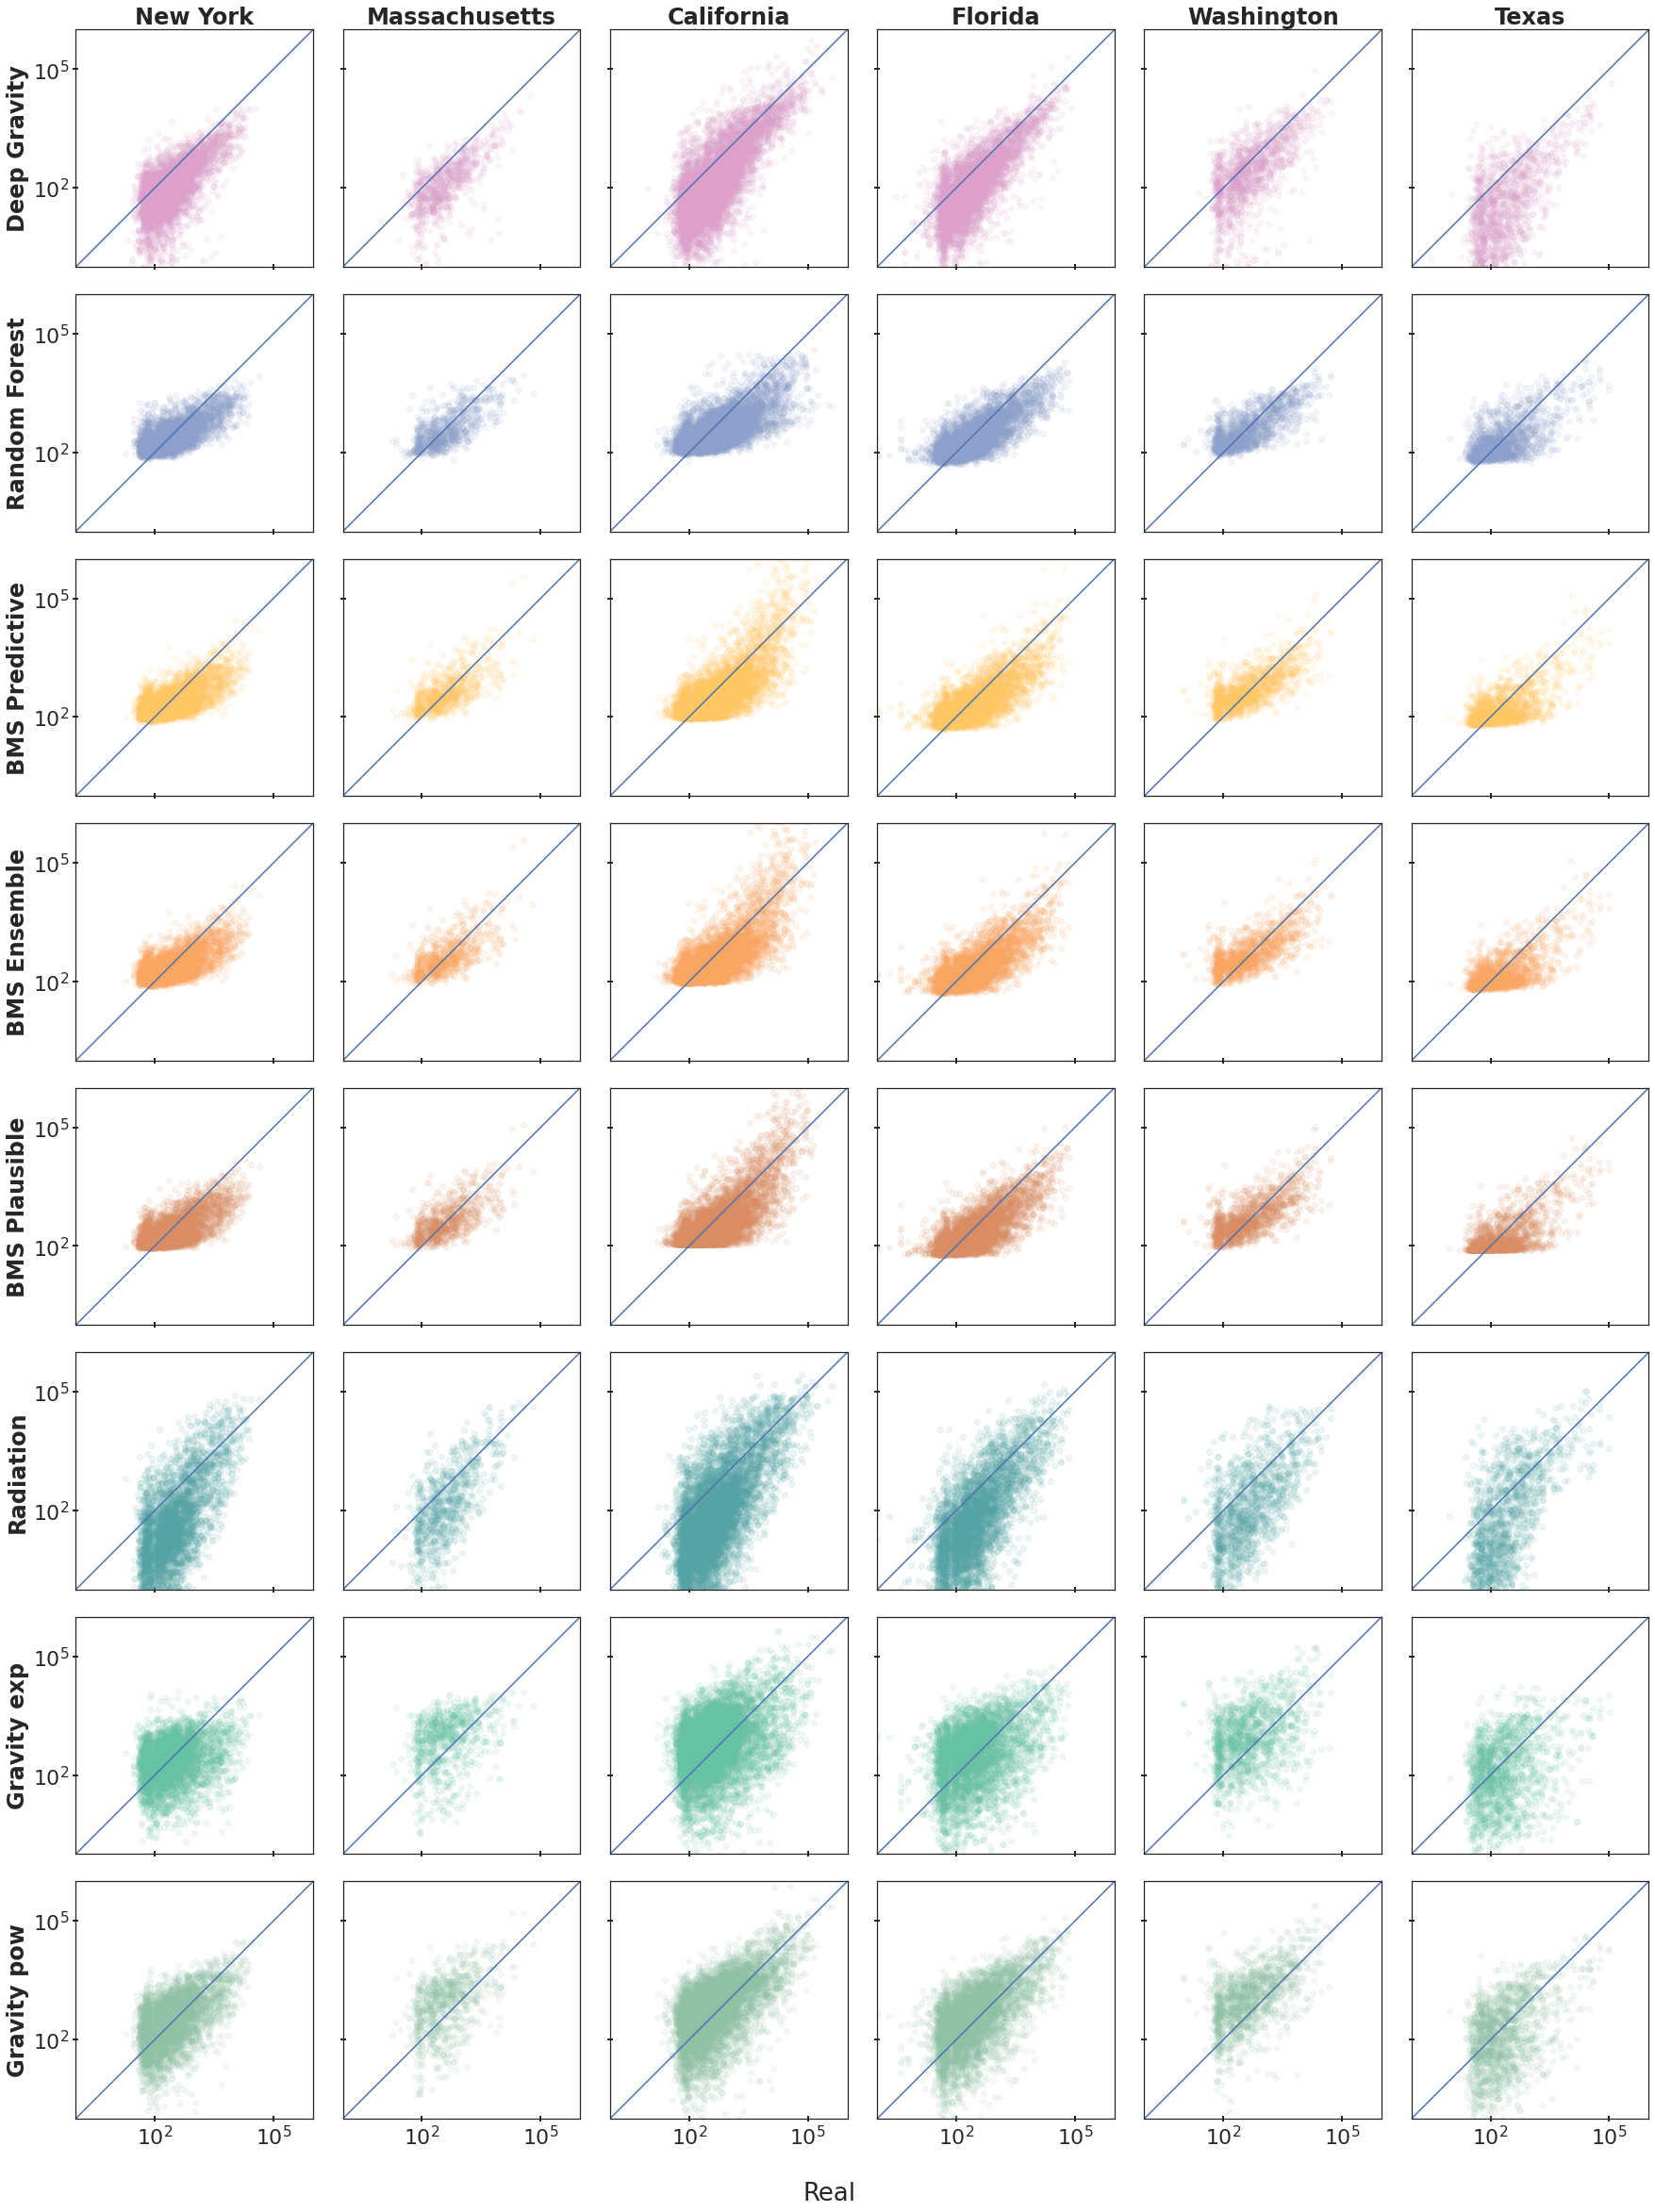

In [18]:
def predictions_state(_dict,mode,models=None,lims=None,list_ticks=None,name=None):
    import matplotlib.cm as cm
    import matplotlib.gridspec as gs
    
    if mode=='A': colors = cm.autumn(np.linspace(0, 1, len(list(_dict[list(_dict.keys())[0]].keys()))))
    if mode=='B': colors = cm.winter(np.linspace(0, 1, len(list(_dict[list(_dict.keys())[0]].keys()))))
    if mode=='C': colors = cm.cool(np.linspace(0, 1, len(list(_dict[list(_dict.keys())[0]].keys()))))
    colors=[[i/255. for i in color_dict[key]]+[1] for key in models]
    colors=colors[::-1]
    #SMALL_SIZE = 26
    #MEDIUM_SIZE = 26
    #BIGGER_SIZE = 26
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    sbrn.set(style='ticks', font_scale=2)
    #fig, axs = plt.subplots(1,len(_dict),figsize=(25, 5),sharey=True)
    #plt.gca().set_aspect('equal')
    fist_state=list(_dict.keys())[0]
    if models==None:
        models=[ k for k in _dict[fist_state].keys() if k!='test']
    fig, axs = plt.subplots(len(models),len(_dict),figsize=(25,33))#,sharey='col',sharex='col')
    mpl.rc('font', family='arial')
    sbrn.set(style='ticks', font_scale=2)
    fig.supxlabel('Real',va='baseline')
    g = gs.GridSpec(6,8)
    g.update(wspace=2.0, hspace=0.3)
    c_count=0
    for i,m in enumerate(models[::-1]):
        
        if m=='test': continue
        #fig, axs = plt.subplots(1,len(_dict),figsize=(25, 5),sharey=True)#,sharex=True)
        alpha=1.
        #colors = cm.rainbow(np.linspace(0, 1, len(_dict[state])))
        for j,state in enumerate(_dict.keys()):
            t='test'
            if m=='Deep Gravity':
                t='testDG'
            axs[i,j].scatter(_dict[state][t], _dict[state][m],label=m, alpha=0.1,c=[colors[i]])#bar_label(deepcopy(p1), label_type=None)
            if j==0: axs[i,j].set_ylabel(m, fontweight="bold")
            if i==0:
                axs[i,j].set_title(state, fontweight="bold")
            axs[i,j].tick_params(direction='inout', width=2)

            axs[i,j].set_yscale('log')
            axs[i,j].set_xscale('log')
            ratio = 1.0
            alpha=alpha-0.1
        #fig.legend(loc=5)
            xleft, xright = axs[i,j].get_xlim()
            ybottom, ytop = axs[i,j].get_ylim()
            minimum = np.min((axs[i,j].get_xlim(),axs[i,j].get_ylim()))
            maximum = np.max((axs[i,j].get_xlim(),axs[i,j].get_ylim()))
        #ax.set_xlim(minimum*1.2,maximum*1.2)
        #ax.set_ylim(minimum*1.2,maximum*1.2)
        #axs.plot((xleft, xright), (ybottom,ytop))
            axs[i,j].plot(lims, lims)
            axs[i,j].tick_params(axis = 'both')
            #axs[i,j].xticks([])
            if list_ticks!=None:
                axs[i,j].set_xticks(list_ticks)
                axs[i,j].set_yticks(list_ticks)
            if j>0: axs[i,j].set_yticklabels([])
            if i<len(models)-1: axs[i,j].set_xticklabels([])
            axs[i,j].set_xlim(lims)
            axs[i,j].set_ylim(lims)
            axs[i,j].set(adjustable='box', aspect='equal')
            c_count+=1
        #plt.tight_layout(h_pad=0.3,w_pad=0.3)
    
    fig.tight_layout()
    #if name!=None:
        #fig.savefig(name,format='pdf')
    fig.show()
    #return fig
predictions_state(scatter_models_C_final_mod,'C',models=['Gravity pow','Gravity exp','Radiation','BMS Plausible','BMS Ensemble','BMS Predictive','Random Forest','Deep Gravity'],
                 lims=(1.,1e6),list_ticks=[1e-1,1e2,1e5],name='./Plots/week2_scatter_plot.pdf')